# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [5]:
def add_lags(df_x, df_y):
    ''' Add lags '''
    target_map = df_y['y'].to_dict()

    df_x['lagDay'] = (
        (df_x.date - pd.DateOffset(days=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)
    
    df_x['lagWeek'] = (
        (df_x.date - pd.DateOffset(days=7))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    return df_x


In [6]:
X_train = create_features(X_train)
X_train = add_lags(X_train, y_train)
X_test = create_features(X_test)
X_test = add_lags(X_test, y_train)

In [7]:
X_train.tail()

,date,station,job,ferie,vacances,day,month,year,dayofweek,lagDay,lagWeek
index,,,,,,,,,,,
2022-12-31_V2P,2022-12-31,V2P,0,0,1,31,12,2022,5,1503.0,1063.0
2022-12-31_N9K,2022-12-31,N9K,0,0,1,31,12,2022,5,760.0,417.0
2022-12-31_P6E,2022-12-31,P6E,0,0,1,31,12,2022,5,112.0,74.0
2022-12-31_BDC,2022-12-31,BDC,0,0,1,31,12,2022,5,70.0,53.0
2022-12-31_W14,2022-12-31,W14,0,0,1,31,12,2022,5,19.0,10.0


In [7]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
#X_train = X_train.drop(columns=['year', 'month', 'day', 'dayofweek'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
#X_test = X_test.drop(columns=['year', 'month', 'day', 'dayofweek'])
X_test['station'] = X_test['station'].astype('category')

In [8]:
# Aplicar Label Encoding para a coluna 'station'
le = LabelEncoder()
X_train['station'] = le.fit_transform(X_train['station'])
X_test['station'] = le.transform(X_test['station'])

In [9]:
X_train.head()

,station,job,ferie,vacances,day,month,year,dayofweek,lagDay,lagWeek
index,,,,,,,,,,
2015-01-01_1J7,24,1,1,1,1,1,2015,3,NaN,NaN
2015-01-01_O2O,295,1,1,1,1,1,2015,3,NaN,NaN
2015-01-01_8QR,107,1,1,1,1,1,2015,3,NaN,NaN
2015-01-01_UMC,367,1,1,1,1,1,2015,3,NaN,NaN
2015-01-01_FK3,199,1,1,1,1,1,2015,3,NaN,NaN


In [ ]:
#X_train.fillna(method='ffill', inplace=True)
#X_test.fillna(method='ffill', inplace=True)

/tmp/ipykernel_32203/3437039292.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train.fillna(method='ffill', inplace=True)
/tmp/ipykernel_32203/3437039292.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method='ffill', inplace=True)


In [ ]:
# Preencher valores ausentes com a média das colunas numéricas
#X_train.fillna(X_train.mean(), inplace=True)
#X_test.fillna(X_test.mean(), inplace=True)

In [10]:
X_train.isna().sum()

station          0
job              0
ferie            0
vacances         0
day              0
month            0
year             0
dayofweek        0
lagDay        7735
lagWeek      14619
dtype: int64

In [11]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=2, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

/home/isarigue/miniconda3/envs/stasc/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)

In [20]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50]  # Número de árvores na floresta
    #'max_depth': [10, 20, 30],  # Profundidade máxima das árvores
    #'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    #'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras em um nó folha
    #'max_features': ['auto', 'sqrt', 'log2'],  # Número de features a serem consideradas para cada split
    #'bootstrap': [True, False]  # Se utilizar amostragem bootstrap para construir as árvores
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True), n_jobs=-1, verbose=100).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3; 1/1] START n_estimators=50.............................................
[CV 1/3; 1/1] START n_estimators=50.............................................
[CV 3/3; 1/1] START n_estimators=50.............................................


/home/isarigue/miniconda3/envs/stasc/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/isarigue/miniconda3/envs/stasc/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/isarigue/miniconda3/envs/stasc/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
print("Best params:", grid_search.best_params_)
for p, i in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f'Score {p}: {i}')

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

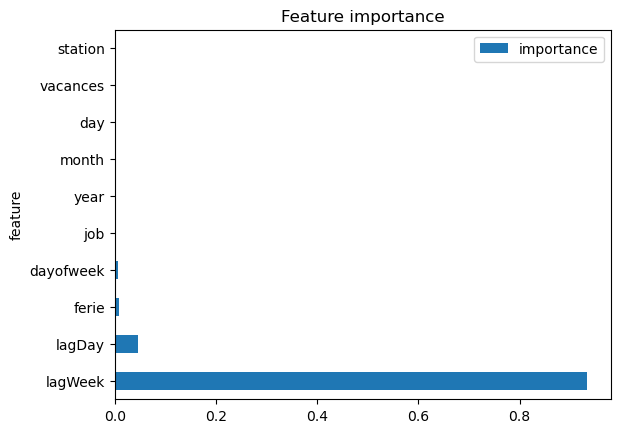

In [12]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [13]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred_vals = rf.predict(X_test)
y_pred['y'] = np.clip(y_pred_vals, 0, None).astype(int) # Clip negative values to 0
y_pred.to_csv(file_path + 'y_pred_rf.csv')

Poisson : deu ruim, as previsões ficaram todos iguais e incoerentes.

Random forests: demora muito pra rodar, não consegui inclusive rodar com o gridsearch. Score: 182, deu muito bom não